In [1]:
from vtl.Readfile import Readfile
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sea
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.io import fits,ascii
from glob import glob
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})

In [2]:
def Get_flux(FILE):
    observ = fits.open(FILE)
    w = np.array(observ[1].data.field('wave'))
    f = np.array(observ[1].data.field('flux')) * 1E-17
    sens = np.array(observ[1].data.field('sensitivity'))
    contam = np.array(observ[1].data.field('contam')) * 1E-17
    e = np.array(observ[1].data.field('error')) * 1E-17
    f -= contam
    f /= sens
    e /= sens

    INDEX = []
    for i in range(len(w)):
        if w[i] < 11900:
            INDEX.append(i)

    w = w[INDEX]
    f = f[INDEX]
    e = e[INDEX]

    return w, f, e

In [3]:
def Get_flux_raw(FILE):
    observ = fits.open(FILE)
    w = np.array(observ[1].data.field('wave'))
    f = np.array(observ[1].data.field('flux')) * 1E-17
    contam = np.array(observ[1].data.field('contam')) * 1E-17
    e = np.array(observ[1].data.field('error')) * 1E-17
    f -= contam

    INDEX = []
    for i in range(len(w)):
        if w[i] < 11900:
            INDEX.append(i)

    w = w[INDEX]
    f = f[INDEX]
    e = e[INDEX]

    return w, f, e

In [60]:
ex_listone = glob('../../../../../../Volumes/Vince_research/Extractions/Quiescent_galaxies/n34694/*1D*')
# ex_listone = glob('../../../Clear_data/extractions_nov_22/GS3/*35774*1D*fits')

In [61]:
print ex_listone

['../../../../../../Volumes/Vince_research/Extractions/Quiescent_galaxies/n34694/GN5-41-014-G102_34694.1D.fits', '../../../../../../Volumes/Vince_research/Extractions/Quiescent_galaxies/n34694/GN5-42-346-G102_34694.1D.fits', '../../../../../../Volumes/Vince_research/Extractions/Quiescent_galaxies/n34694/GN5-43-346-G102_34694.1D.fits', '../../../../../../Volumes/Vince_research/Extractions/Quiescent_galaxies/n34694/GN5-44-052-G102_34694.1D.fits', '../../../../../../Volumes/Vince_research/Extractions/Quiescent_galaxies/n34694/GN5-45-052-G102_34694.1D.fits', '../../../../../../Volumes/Vince_research/Extractions/Quiescent_galaxies/n34694/GN5-G102_34694.1D.fits']


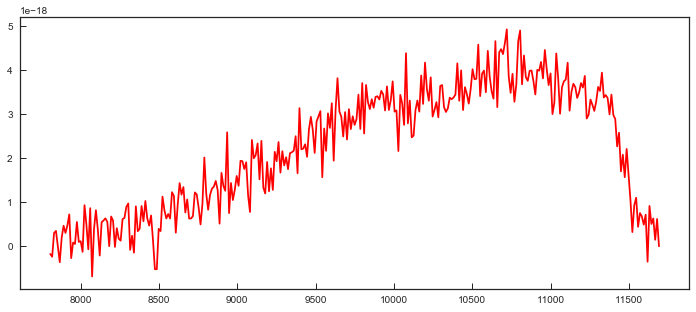

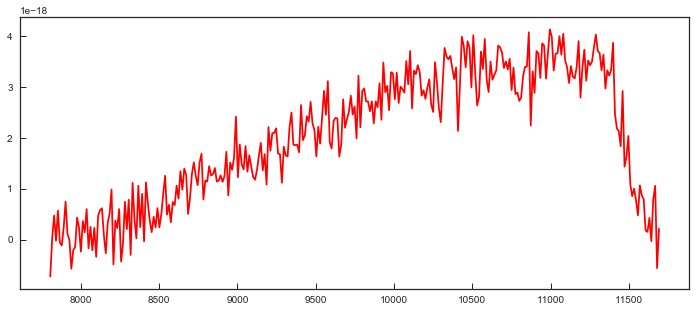

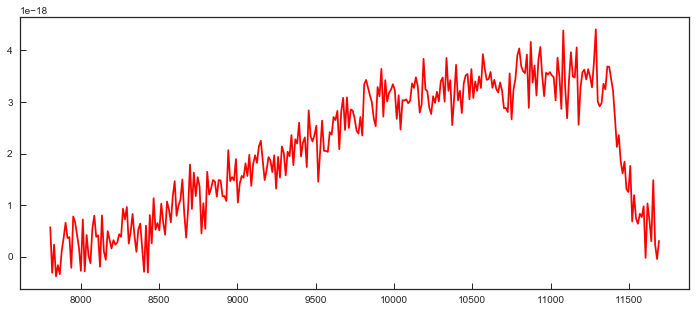

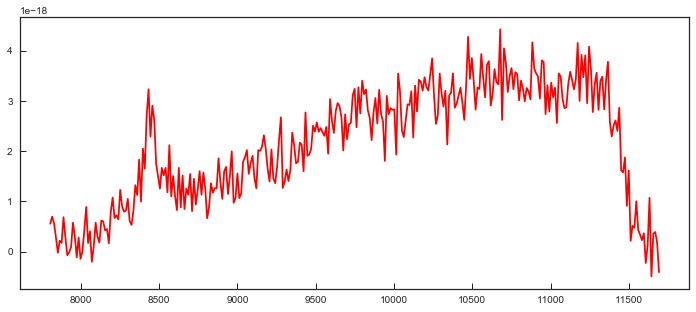

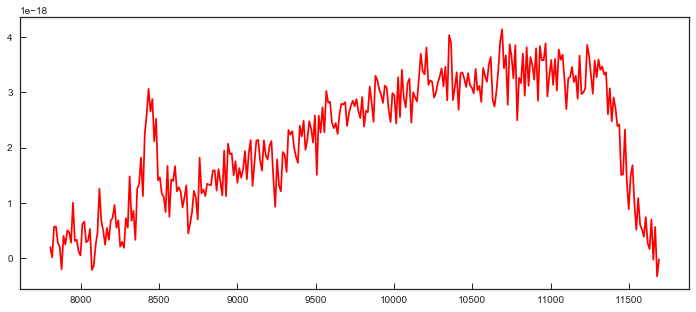

In [62]:
%matplotlib inline


for i in range(len(ex_listone[0:-1])):
    wv,fl,er = Get_flux_raw(ex_listone[i])
    IDX = np.array([U for U in range(len(wv)) if 7800 < wv[U] < 11700]).astype(int)
    
#     wv2,fl2,er2 = Get_flux(ex_listone[i])
#     IDX2 = np.array([U for U in range(len(wv2)) if 7800 < wv2[U] < 11700]).astype(int)
    
#     plt.figure(figsize=[12,5])
#     plt.plot(wv2[IDX2],fl2[IDX2])
#     plt.ylim(0,5E-18)
# #     plt.axvline(11200)
#     plt.show()
#     plt.close()
    
    plt.figure(figsize=[12,5])
    plt.plot(wv[IDX],fl[IDX],'r')
#     plt.axvline(11200)
    # plt.ylim(0,5E-18)
    plt.show()
    plt.close()